TODO: Make images same aspect ratio and size

In [35]:
import sys
print(sys.version)
from __future__ import division, absolute_import, print_function
from IPython.display import Audio
from ipywidgets import widgets
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import FormatStrFormatter
from scipy import signal
%matplotlib inline
plt.style.use('ggplot')
import pydot  # to regenerate the Graphviz figures you need 'dot' to be accessible in your path
from brian import *
from brian.hears import *
from scipy.signal import butter, lfilter
#set_global_preferences(useweave=True)  # uncomment to use faster C implementations in Brian
#set_global_preferences(gcc_options = ['-ffast-math -march=native'])
#set_global_preferences(openmp=True)  # uncomment to use multiple cores in Brian

2.7.12 |Anaconda 4.2.0 (32-bit)| (default, Jun 29 2016, 11:42:13) [MSC v.1500 32 bit (Intel)]


# <center>Signalverarbeitung und Codierung in Cochlea-lmplantaten</center>


### <center>Version: 2016-01-12</center>

### <center>Autor: Dr. Stefan Strahl (stef@nstrahl.de)</center>

Diese Vorlesung ist ein interaktives Jupyter Notebook, verfügbar unter https://github.com/strahl/lecture

Ihr könnt das Notebook mit dem Jupyter Notebook Viewer lesen https://nbviewer.jupyter.org/

Ihr könnt Jupyer und Python auf eurem eigenen Rechner installieren: http://jupyter.org/



## 1. Signalverarbeitung des periphären auditorischen Systems
![Äußeres Ohr, Mittelohr und Innenohr mit Hörschnecke, Sacculus und Bogengängen](images/Äußeres_Ohr_-_Mittelohr_-_Innenohr.jpg)
<div style="text-align: right">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:%C3%84u%C3%9Feres_Ohr_-_Mittelohr_-_Innenohr.jpg)</div>

Zuerst wollen wir uns genauer anschauen wie unser periphäres auditorisches System arbeitet. Die Geräusche gelangen hauptsächlich als Luftdruckänderungen durch den äusseren Gehörgang zum Trommelfell. Im Bereich des Mittelohrs lenkt dann das Trommelfell über die Impedanzwandler Hammer, Amboss und Steigbügel das ovale Fenster der Hörschnecke aus. Dadurch kommt die Perilymphe im Innenohr in Schwingung.

###  Basilarmembran: Die Frequenz-Orts-Transformation
![Uncoiled Basilar Membrane](images/Uncoiled_cochlea_with_basilar_membrane.png)
<div style="text-align: right">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Uncoiled_cochlea_with_basilar_membrane.png)</div>

Die durch den Schall erzeugt Wanderwelle läuft durch das Innenohr. Was fällt auf wenn man sich die Basilarmembran anschaut? Die Breite der Basilarmembran nimmt Richtung Apex zu. Da gleichzeitig der Durchmesser des knöchernen Schneckenkanals abnimmt, ändern sich die Schwingungseigenschaften des Systems von steif und resonant mit hohen Frequenzen am Anfang zu nachgiebig und resonant mit niedrigen Frequenzen am Apex.

###  Innenohr: Von der Basilarmembran zum Hörnerven 
![Cochlea crosssection](images/Cochlea-crosssection-de.png)
<div style="text-align: right">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Cochlea-crosssection-de.png)</div>

Mit der  Auslenkung der Basilarmembran werden die inneren Haarzellen angeregt. Der Reiz löst ein elektrisches Signal in den Haarzellen aus (mechano-elektrische Transduktion). Diese geben ein chemisches Signal (Transmitter Glutamat) an eine Hörnervenfaser (Transformation), wodurch jede Hörnervenfaser die Frequenzselektion ihrer angeschlossenen inneren Haarzelle weitergibt. Die Hörnervenfasern reagieren elektrisch (Aktionspotential) und reichen bis zum ersten Kerngebiet der Hörbahn im Stammhirn.

Im nächsten Abschnitt wollen wir diese Etappen in der Höhrbahn simulieren:

In [105]:
def simulate_acoustic(sound, level):
    basilar_membran_position_mm = np.linspace(0, 32, 200)  # 
    cfmin, cfmax, cfN = 20*Hz, 20*kHz, len(basilar_membran_position_mm)
    center_frequencies = erbspace(cfmin, cfmax, cfN)
    
    sound.level = level
    gfb = Gammatone(sound, center_frequencies)
    gt_mon = gfb.process()
    ihc = FunctionFilterbank(gfb, lambda x: 3*clip(x, 0, Inf)**(1.0/3.0))
    ihc_mon = ihc.process()
    # Leaky integrate-and-fire model with noise and refractoriness
    eqs = '''
    dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1
    I : 1
    '''
    G = FilterbankGroup(ihc, 'I', eqs, reset=0, threshold=1, refractory=5*ms)
    # Run, and raster plot of the spikes
    M = SpikeMonitor(G)
    run(sound.duration)

    fig, axes2d = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
    axes = axes2d.flatten()
    axes[0].plot(1e3*sound.times, sound);
    axes[0].set_ylabel('Amplitude (Pa)');
    axes[0].set_title('Tonsignal')
        
    plt.sca(axes[1])
    plt.imshow(gt_mon.T, aspect='auto', origin='lower left',
           extent=(0, sound.duration/ms,
                   1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    axes[1].set_title('Basilarmembranauslenkung');
    axes[1].set_ylabel('Frequenz (kHz)');
    axes[1].set_yticks(center_frequencies[::49]*1e-3, minor=False)
    ax2 = axes[1].twinx()    
    ax2.set_ylim(axes[1].get_ylim())
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.yticks(axes[1].get_yticks(), ["{:1.1f}".format(c) for c in basilar_membran_position_mm[[0,49,98,147,196]]])
    ax2.set_ylabel('Position (mm)')    

    plt.sca(axes[2])
    plt.imshow(ihc_mon.T, aspect='auto', origin='lower left',
           extent=(0, sound.duration/ms,
                   1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    axes[2].set_title('IHC Antwort');
    axes[2].set_ylabel('Frequenz (kHz)');
    axes[2].set_xlabel('Zeit (ms)');
    axes[2].set_yticks(center_frequencies[::49]*1e-3, minor=False)
    
    plt.sca(axes[3])
    raster_plot(M)
    axes[3].set_title(u'Hörnervenaktivität');
    axes[3].set_xlabel('Zeit (ms)');
    axes[3].set_ylabel('Neuron');    
    axes[3].set_ylim((0,len(M.spiketimes)))
    ax2 = axes[3].twinx()    
    ax2.set_ylim(axes[3].get_ylim())
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.yticks(axes[3].get_yticks(), ["{:1.1f}".format(c) for c in basilar_membran_position_mm[[0,50,100,150,199]]])
    ax2.set_ylabel('Position (mm)')    

    fig.tight_layout() 
    return M

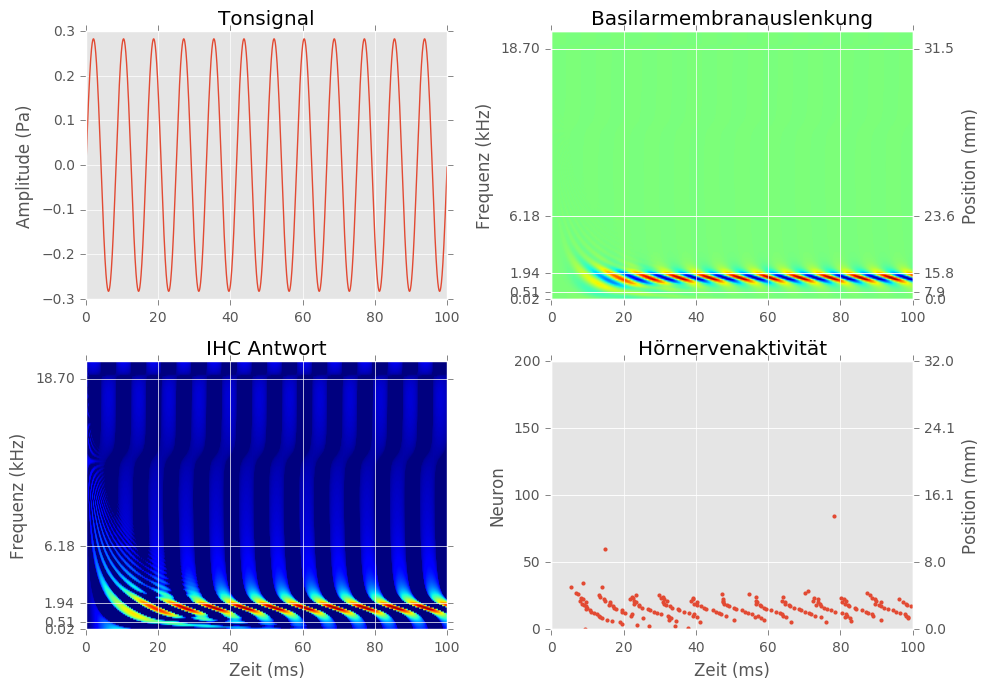

In [108]:
sound = tone(120*Hz, .1*second)
# Hier können eigene Beispiele ausprobiert werden, z.B. sound = tone(100*Hz, .1*second) + tone(150*Hz, .1*second) + tone(200*Hz, .1*second)
# sound = loadsound('sounds/Open_front_unrounded_vowel.wav')  # Vokal
an_response_acoustic = simulate_acoustic(sound, 80*dB)
Audio(data=np.array(sound).T, rate=sound.samplerate)

Bei dem 100 Hz Sinuston sieht man sehr schön das Phaselocking der Nervenfasern, d.h. die Neurone feuern nur ca. alle 10 ms. Es steht dem auditorischen System also neben der Ortskodierung (oft "place-coding" gennant) auch eine Zeitinformation zur Verfügung ("time-coding"). Wenn wir drei Sinustöne (100, 150, 200 Hz) sehen wir Zeitversatz der Wanderwelle. Wir sehen auch die Anregungsbreite. Wenn wir 100, 300, 500 Hz ausprobieren sehen wir erst ein Trennung der Kanäle. Die nichtlineare Frequenzachse, die auch rechts an der Basilarpos in mm Achse gut erkennbar.

Beim Vokal und Sprachbeispiel sieht man: Es gibt eine Einhüllende (2-20 Hz), eine Periodizität aufgrund der F0 Grundfrequenz und eine zeitliche Feinstruktur.

Jetzt kennen wir die Verarbeitung unseres Hörsystems vom Schall zur den Aktionspotentialen im Hörnerven.

## 2. Aufbau eines Cochleaimplantats
![MED-EL CONCERTO](images/medel_durchsicht.jpg)
<div style="text-align: right">[Quelle: MED-EL](https://www.medel.com)</div>

Ein CI kann direkt die Hörnerven stimulieren wenn der normale Signalweg gestört ist. Ein typisches Cochleaimplantat besteht aus einer Spule mit einem Magneten, einem Gehäuse für die Stimulationslogik, einem Elektrodenarray mit Kontakten sowie mindestens einer Referenzelektrode bezüglich der Stimulation sowie optional einer Referenzelektrode für etwaige Spannungsmessungen.

![Henry Gray (1918) Anatomy of the Human Body](images/Gray928.png)
<div style="text-align: right">[Quelle: Gray (1918)](https://commons.wikimedia.org/wiki/File:Gray928.png)</div>
Wo würdest ihr den Elektrodenträger implantieren?

![Henry Gray (1918) Anatomy of the Human Body](images/Gray928_electrode.png)
<div style="text-align: right">[Quelle: Gray (1918)](https://commons.wikimedia.org/wiki/File:Gray928.png)</div>
Der Elektrodenträger wird durch das runde Fenster in die Scala tympani inseriert. Es wird die Scala tympani verwendet, da in der Scala vestibuli das Spiralorgan leichter beschädigt werden kann.

In [162]:
(graph,) = pydot.graph_from_dot_data("digraph G {rankdir = LR node [shape=box]; A [label=\"Mikrofon\"]; B [label=\"Vor-\nverarbeitung\"]; C [label=\"Stimulations-\nstrategie\"]; D [label=\"RF\nSpule\"]; E [label=\"Dekoder\"]; F [label=\"Puls\nErzeugung\"]; G [label=\"Elektroden\"]; A -> B; B -> C; C -> D; D -> E; E -> F;  F -> G}")
graph.write_svg('./images/signal_chain_basic.svg');

##  3. Signalverarbeitung eines CI
![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Mikrofon__
* üblicher Frequenzbereich von 100 - 8000 Hz
* 1-2 omnidirektionale Mikrofone 

__Vorverarbeitung__: 
* Automatische Verstärkungsregelung (AGC)
* Beamforming
* Windgeräuschunterdrückung
* ...

__Stimulationsstrategie__:
* Erzeugung des Stimulationsmuster
* Generierung des digitalen Datenwortes
* kennt die individuelle Anpassung des CI Nutzers

__RF Spule__:
* Übertragung des digitalen Datenwortes durch die Haut in den implantierten Stimulator
* gleichzeitige Energieversorgung

__Dekoder__:
* Dekodierung der RF Signale
* Prüfsummenberechnung

__Pulserzeugung__:
* eine oder mehrere Stromquellen
* Kanal: zwei oder mehr Elektroden zwischen denen ein Stromfluss stattfindet

__Elektroden__:
* 12-24 intracochleäre Elektroden
* 1-3 Referenzelektroden am Stimulatorgehäuse
* monopolar: entferne Referenzelektrode
* bipolar: Strom fliesst zwischen zwei intracochleären Elektroden

##  3.1 Einkanalige Stimulation
Die ersten Cochleaimplantate waren einkanalige Geräte. Zum Beispiel wurde ein CI im House Ear Institute, USA entwickelt, welches das Audiosignal mit einem Bandpassfilter im Sprachrelevanten Bereich von 340-2700 Hz auswertete. Die Ausgabe des Bandpassfilters wurde dann auf einen 16 kHz Träger moduliert und direkt an der in der Hörschnecke sich befindenden Elektrode appliziert.
![3M/House single-channel cochlear implant](images/Houseimplant_large.jpg)
<div style="text-align: right">[Quelle: Washington University School of Medicine](http://beckerexhibits.wustl.edu/did/win_tl/Houseimplant.htm)</div>

In [20]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def simulate_house(sound):
    basilar_membran_position_mm = np.linspace(0, 32, 200)  # 
    cfmin, cfmax, cfN = 20*Hz, 20*kHz, len(basilar_membran_position_mm)
    center_frequencies = erbspace(cfmin, cfmax, cfN)
    
    bandpass = IIRFilterbank(source=sound, nchannels=1, passband=np.array((340*Hz, 2700*Hz)), stopband=np.array((300*Hz, 3000*Hz)), gpass=1.*dB, gstop=10.*dB, btype='bandpass', ftype='cheby1')
    bp_mon = bandpass.process()
    carrier = np.sin(16000*2*np.pi*sound.times)
    processed = Sound(bp_mon[:,0] * carrier, samplerate=sound.samplerate)

    energy = FunctionFilterbank(processed, lambda x: abs(x))
    impulse_response = zeros((len(basilar_membran_position_mm),1))
    impulse_response[:,0] = 5*gaussian(np.arange(len(basilar_membran_position_mm)), 150, 10)
    electric_field = FIRFilterbank(energy, impulse_response)
    ef_mon = electric_field.process()

    # Leaky integrate-and-fire model with noise and refractoriness
    eqs = '''
    dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1
    I : 1
    '''
    G = FilterbankGroup(2*electric_field, 'I', eqs, reset=0, threshold=1, refractory=5*ms)
    # Run, and raster plot of the spikes
    M = SpikeMonitor(G)
    run(sound.duration)

    plt.rcParams['figure.figsize'] = (10, 7)

    ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
    ax3 = plt.subplot2grid((2, 6), (1, 0), colspan=2)
    ax4 = plt.subplot2grid((2, 6), (1, 2), colspan=2) 
    ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2) 

    plt.sca(ax1)        
    plt.plot(1e3*sound.times, sound);
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Amplitude (Pa)');
    plt.title('Tonsignal')

    # bandpass filter & 16 kHz carrier
    plt.sca(ax2)
    plt.plot(1e3*sound.times, bp_mon);
    plt.plot(1e3*sound.times, processed);
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Spannung (V)');
    plt.title('Verarbeitetes Signal')
    axins = inset_axes(ax2, width="30%", height="30%", loc=1)
    axins.plot(1e3*sound.times, bp_mon);
    axins.plot(1e3*sound.times, processed);
    axins.set_xlim(301, 303)
    axins.set_ylim(-0.55, 0.55)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(ax2, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    # spread of excitation
    plt.sca(ax3)
    imshow(ef_mon.T, aspect='auto', origin='lower left',
               extent=(0, sound.duration/ms, 1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Frequenz (kHz)');
    plt.title('Elektrische Anregung')

    plt.sca(ax4)
    # Leaky integrate-and-fire model with noise and refractoriness
    raster_plot(M)
    ylabel('Neuron');    
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));
    plt.title('Nervenantwort elektrisch')

    plt.sca(ax5)
    raster_plot(an_response_acoustic)
    ylabel('Neuron');
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));
    plt.title('Nervenantwort akustisch')
    
    plt.gcf().tight_layout()
    return processed

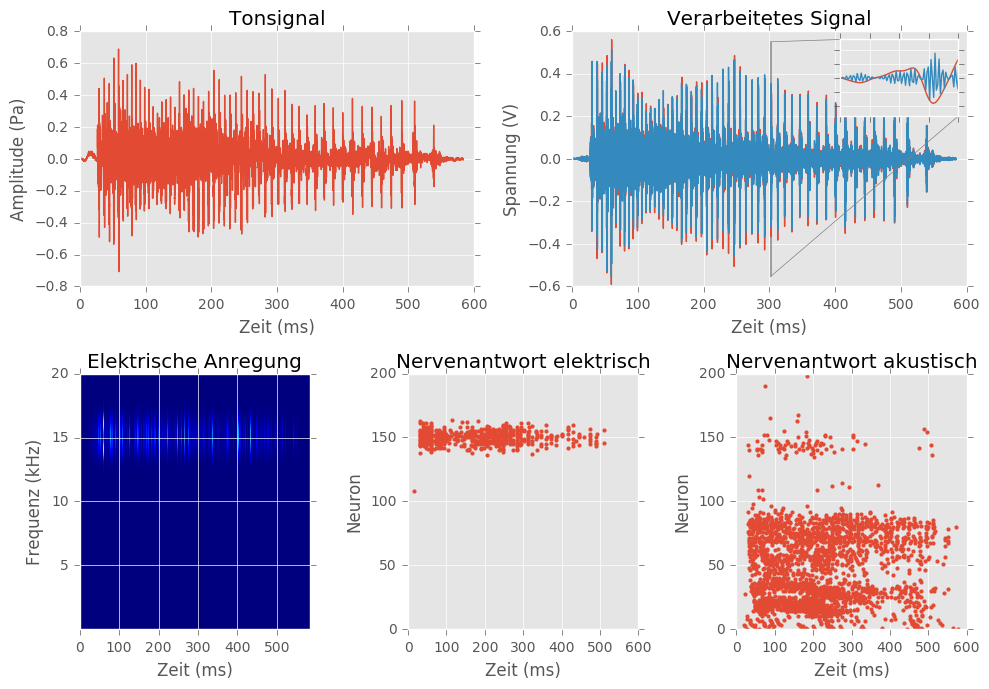

In [23]:
sound = loadsound('sounds/Open_front_unrounded_vowel.wav')
processed = simulate_house(sound)

##  3.2 Mehrkanalige Stimulation
Eine Satzerkennung war mit einkanaligen CIs kaum möglich. Daher wurde Ende der 70er die ersten mehrkanalige CIs entwickelt. 1977 wurde z.B. in Wien ein 8-Kanal CI implantiert.

![](images/1977_multichannel.jpg)
<div style="text-align: right">[Quelle: MED-EL](https://www.medel.com)</div>

In [72]:
def gen_bandpassnoise(lowcut, highcut, samples, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, np.random.rand(samples))
    return y

def sonify_CI(sound, num_electrodes, cfmin=1000*Hz, cfmax=16e3*Hz, quantization_ms=5):
    if num_electrodes == 1:
        electrode_cfs = [cfmax+cfmin/2]
    else:
        electrode_cfs = erbspace(cfmin, cfmax, num_electrodes)
    
    stepSize_pts = int(np.round(1e-3*quantization_ms * sound.samplerate))
    numData = sound.nsamples
    time = np.arange(stepSize_pts)/sound.samplerate
    sound_out = np.zeros(numData)

    gfb = Gammatone(sound, electrode_cfs)
    gfb_mon = gfb.process().T
           
    stimData = np.zeros((num_electrodes, stepSize_pts))
    for jj in range(num_electrodes):
        stimData[jj,:] = np.sin(2*np.pi*electrode_cfs[jj]*time)  # sinus
        #stimData[jj,:] = gen_bandpassnoise(electrode_cfs[jj]*0.9, electrode_cfs[jj]*1.1, stepSize_pts, fs=sound.samplerate) # bandpass noise
        # todo: use bandpass noise
                
    for ii in np.arange(0, numData-stepSize_pts+1, stepSize_pts, dtype=int):        
        energy = np.sum(gfb_mon[:,ii:(ii+stepSize_pts)]**2, 1)                             
        newStim = energy.T.dot(stimData)
        sound_out[ii:(ii+stepSize_pts)] = newStim                
    
    # normalize sound
    sound_out = sound_out - np.min(sound_out)
    sound_out = 2*sound_out/np.max(sound_out)-1
    
    t = np.arange(len(sound))/sound.samplerate
    plt.rcParams['figure.figsize'] = (10, 7)
    plt.subplot(2,2,1)
    plt.plot(t, sound)
    plt.xlabel('Zeit (s)');
    plt.ylabel('Amplitude (Pa)');
    plt.title('Tonsignal')
    plt.subplot(2,2,2)
    sound.spectrogram()
    plt.title('Spectrogram Tonsignal')
    plt.xlabel("Zeit (s)")
    plt.ylim(0,15000)
    plt.subplot(2,2,3)
    plt.plot(t, sound_out)
    plt.xlabel("Zeit (s)")
    plt.ylabel("Amplitude (Pa)")
    plt.title('simuliertes CI Signal')
    plt.subplot(2,2,4)
    Sound(sound_out, samplerate=sound.samplerate).spectrogram()
    plt.ylim(0,15000)
    plt.plot(t[-1]*np.ones((len(electrode_cfs,))),electrode_cfs,"w*", ms=10.0)
    plt.xlabel("Zeit (s)")
    plt.title('Spectrogram simuliertes CI Signal')
    plt.gcf().tight_layout() 
    
    return sound_out, electrode_cfs

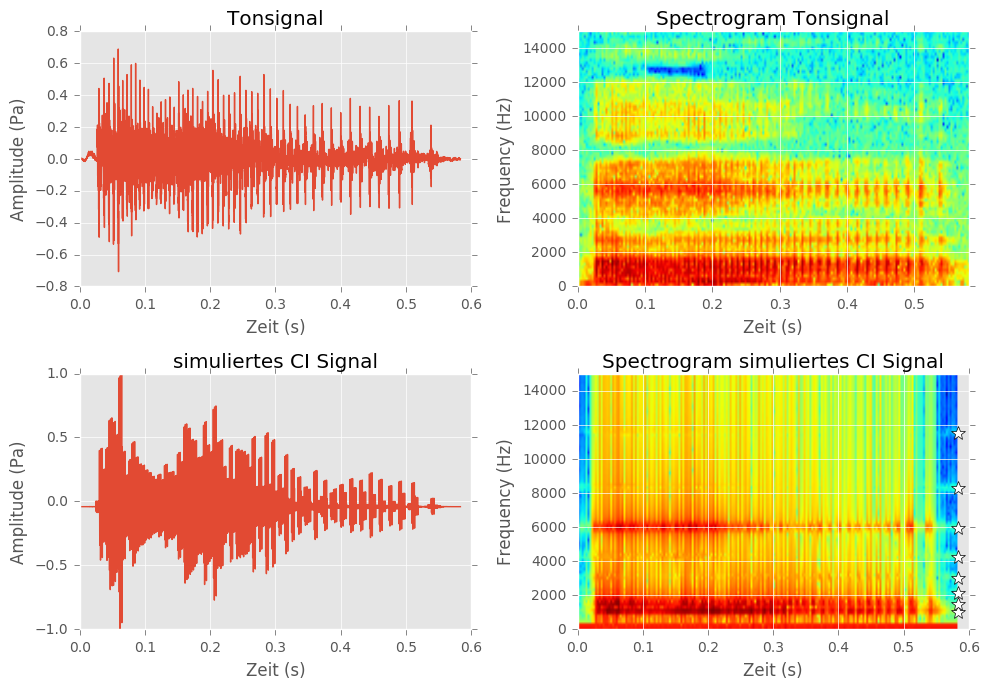

In [102]:
sound = loadsound('sounds/Open_front_unrounded_vowel.wav')
#sound = loadsound('sounds/voice1.wav')
#sound = loadsound('sounds/music1.wav')
sound_ci, electrode_cfs = sonify_CI(sound, num_electrodes=9, cfmin=1000*Hz, cfmax=16e3*Hz)
#sound_ci, electrode_cfs = sonify_CI(sound, num_electrodes=9, cfmin=300*Hz, cfmax=16e3*Hz)
Audio(data=sound_ci, rate=sound.samplerate)
#Audio(data=sound.T, rate=sound.samplerate)

Könnt ihr das Sprach- und Musikbeispiel erraten?

Die Sterne zeigen die Mittenfrequenzen der Stimulationskanäle auf der Basilarmembran. Wie im akutstischen Modell schon gesehen, sind die Position in der Hörschnecke nicht äquidistant über die Frequenzachse. Das bedeutet dass die meisten CIs nur die Nervenfasern für die hohen und mittleren Frequenzen erreichen. Wie ändert sich der Ton wenn ich die Positionen der Elektroden verändere?

Trotzdem war der Erfolg der meisten Mehrkanal-CI Nutzer nicht befriedigend. Der Grund war die breite der elektrischen Anregung. Was meint ihr wie breit ist das elektrisch Feld in Millimeter entlang der Basilarmembran?

In [92]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def simulate_electric(sound, num_electrodes, cfmin=100*Hz, cfmax=8e3*Hz, spread=10):
    if num_electrodes == 1:
        electrode_cfs = [cfmax+cfmin/2]
    else:
        electrode_cfs = erbspace(cfmin, cfmax, num_electrodes)
    
    passbands = np.zeros((2, num_electrodes))
    stopbands = np.zeros((2, num_electrodes))
    
    for el in np.arange(num_electrodes):
        passbands[0,el] = (1-spread/100.)*electrode_cfs[el]*Hz
        passbands[1,el] = (1+spread/100.)*electrode_cfs[el]*Hz
        stopbands[0,el] = passbands[0,el] - 50
        stopbands[1,el] = passbands[1,el] + 50

    basilar_membran_position_mm = np.linspace(0, 32, 200)  # 
    cfmin, cfmax, cfN = 20*Hz, 20*kHz, len(basilar_membran_position_mm)
    center_frequencies = erbspace(cfmin, cfmax, cfN)
    
    bandpass = IIRFilterbank(source=sound, nchannels=num_electrodes, passband=passbands, stopband=stopbands, gpass=1.*dB, gstop=10.*dB, btype='bandpass', ftype='cheby1')
    bp_mon = bandpass.process()
    carrier = np.sin(1000*2*np.pi*sound.times)
    processed = Sound(np.sum(bp_mon) * carrier, samplerate=sound.samplerate)

    energy = FunctionFilterbank(processed, lambda x: abs(x))
    impulse_response = zeros((len(basilar_membran_position_mm),1))
    impulse_response[:,0] = 5*gaussian(np.arange(len(basilar_membran_position_mm)), 150, spread)
    electric_field = FIRFilterbank(2*energy, impulse_response)
    ef_mon = electric_field.process()

    # Leaky integrate-and-fire model with noise and refractoriness
    eqs = '''
    dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1
    I : 1
    '''
    G = FilterbankGroup(electric_field, 'I', eqs, reset=0, threshold=1, refractory=5*ms)
    # Run, and raster plot of the spikes
    M = SpikeMonitor(G)
    run(sound.duration)

    plt.rcParams['figure.figsize'] = (10, 3)

    # spread of excitation
    plt.subplot(1,3,1)
    imshow(ef_mon.T, aspect='auto', origin='lower left',
               extent=(0, sound.duration/ms, 1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    plt.colorbar()

    plt.subplot(1,3,2)
    # Leaky integrate-and-fire model with noise and refractoriness
    raster_plot(M)
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));

    plt.subplot(1,3,3)
    raster_plot(an_response_acoustic)
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));
    return processed

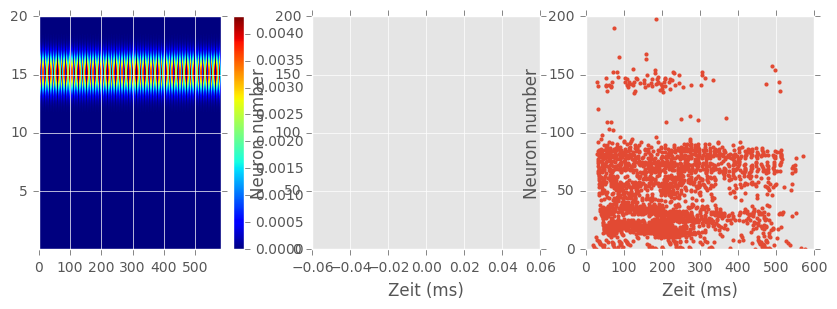

In [103]:
sound = loadsound('sounds/Open_front_unrounded_vowel.wav')
simulate_electric(sound, num_electrodes=1, spread=10);

Wir sehen dass durch die grosse Anregungsbreite der elektrischen Pulse nicht mehr als 9 Elektroden gleichzeitig nutzbar sind. Was könnten wir machen um dieses Kanalübersprechen zu verringern? Eine Idee ist die Pulse zeitversetzt zu präsentieren (wurde "supersampler" genannt)

##  3.3 Aktuelle Stimulationsstrategien
##  3.3.1 Continuous Interleaved Sampling (CIS)
* Kanalübersprechen soll minimiert werden
* Idee: Zeitlicher Versatz der Stimulationspulse
* hohe Stimulationsrate
* ein viel grösseres Spektrum als bisher kodiert

Erst mit CIS erreichten die meisten CI Nutzer offenes Sprachverstehen

![](images/Continuous_Interleaved_Sampling.jpg)
<div style="text-align: right">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Continuous_Interleaved_Sampling.jpg)</div>

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_CIS.png)
<div style="text-align: right">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

##  3.3.2 ACE
Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_ace.png)
<div style="text-align: right">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>
Because frequency bands containing relatively low signal levels are not represented in the stimulation pattern, ACE can
enhance certain spectral features when perceived by CI users. This may be one reason that several studies of
speech understanding have demonstrated slightly higher scores for ACE than CIS [21]. For example, Skinner et al
[22] reported that CI listeners in two separate comparison
studies scored about 6-9 percentage points higher, on
average, in sentence tests when using ACE rather than
CIS.

## 3.3.3 FSP / FS4
* Alle bisherigen Kodierungsstrategien übertragen die Information über den Ort (place-coding)
* Idee: Die zeitlichen Hörnervenmuster (time-coding) an den tieffrequenten apikalen Elektroden reproduzieren

![](images/medel_finehearing-time-coding.jpg)
<div style="text-align: right">[Quelle: MED-EL](https://www.medel.com)</div>

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_fsp.png)
<div style="text-align: right">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>


## 3.3.4 HiRes120
* aktive Steuerung des Anregungsortes (120 virtuelle Kanäle mit 16 Elektroden bipolar)

![](images/AB_HiRes120.png)
<div style="text-align: right">[Quelle: Advanced Bionics](https://www.advancedbionics.com)</div>

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_hires120.png)
<div style="text-align: right">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

## 3.3.5 MP3000
Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster 
:-------------------------:|:-------------------------: |:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_mp3000.png)
<div style="text-align: right">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>
MP3000: . However, overall subject preferences
were equally distributed between the two strategies, and
additional parameters have to be ﬁtted in the MP3000
mapping sessions.

Welche Satzerkennungsrate schätzt ihr erreichen die modernen Kodierungsstrategien

Alle aktuellen Kodierungsstrategien erreichen eine Satzerkennungsrate von ca 80%.

![](images/Zeng2008Fig3.png)
<div style="text-align: right">[Quelle: Zeng at al. (2008)](http://ieeexplore.ieee.org/document/4664429/)</div>
